Original Image

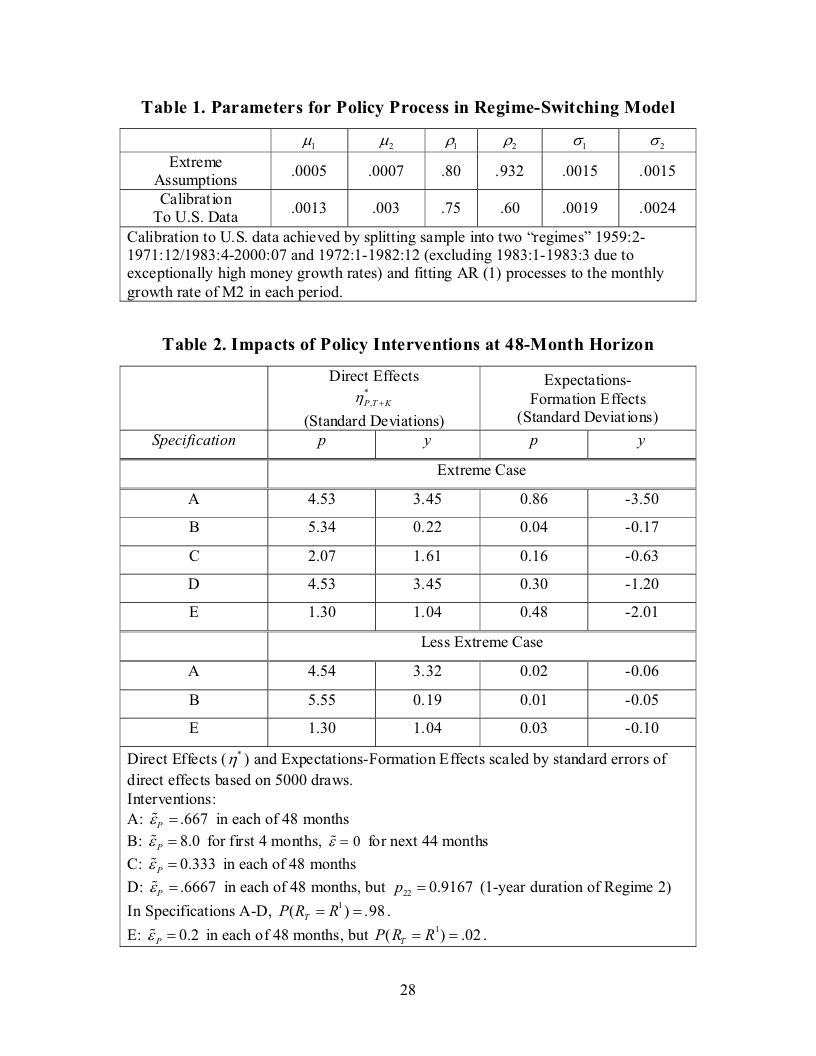

In [21]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

import datetime

from PIL import Image
import statistics
import pytesseract

In [22]:
image_height=1024
image_width=1024

In [23]:
def normalize(input_image):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    #input_mask -= 1
    return input_image

In [24]:
def decode_image(image):
    img=tf.io.decode_jpeg(image)
    img=tf.image.resize(img, [image_height, image_width])
    return img

In [25]:
def decode_mask(image):
    img=tf.io.decode_jpeg(image,channels=1)
    img=tf.image.resize(img, [image_height, image_width])
    return img

In [26]:
def process_1(file_paths):
    img = normalize(decode_image(tf.io.read_file(file_paths)))
    return img

In [27]:
def process_2(file_paths):
    img = normalize(decode_image(tf.io.read_file(file_paths)))
    
    mask_path=tf.strings.regex_replace(file_paths,'.jpg','.jpeg')
    
    tab_mask=tf.strings.regex_replace(mask_path,"Image_Data", "Table_Data")
    col_mask=tf.strings.regex_replace(mask_path,"Image_Data", "Column_Data")
    
    table_mask = normalize(decode_mask(tf.io.read_file(tab_mask)))
    column_mask=normalize(decode_mask(tf.io.read_file(col_mask)))
    
    return img, {'table_mask':table_mask,'column_mask':column_mask}

In [28]:
def create_mask(pred_mask1, pred_mask2):
    pred_mask1 = tf.argmax(pred_mask1, axis=-1)
    pred_mask1 = pred_mask1[..., tf.newaxis]
    
    pred_mask2 = tf.argmax(pred_mask2, axis=-1)
    pred_mask2 = pred_mask2[..., tf.newaxis]
    return pred_mask1[0], pred_mask2[0]

In [29]:
def show_prediction_sample_image(dataset=None, num=1):
    
    model = tf.keras.models.load_model('../input/model50/all/mymodel_45')
    
    for image in dataset.take(num):
        pred_mask1, pred_mask2 = model.predict(image, verbose=1)
        table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
        
        im=tf.keras.preprocessing.image.array_to_img(image[0])
        im.save('image.bmp')
        
        im=tf.keras.preprocessing.image.array_to_img(table_mask)
        im.save('table_mask.bmp')
        
        im=tf.keras.preprocessing.image.array_to_img(column_mask)
        im.save('column_mask.bmp')
        
        return True

In [30]:
def generate_segment():
    img_org  = Image.open('./image.bmp')
    img_mask = Image.open('./table_mask.bmp')

    img_mask = img_mask.convert('L')
    img_org.putalpha(img_mask)
    img_org.save('output.png')

In [31]:
def ocr_core(filename):
    text = pytesseract.image_to_string(Image.open(filename))  # We'll use Pillow's Image class to open the image and pytesseract to detect the string in the image
    return text

In [32]:
def get_mask(dataset=None, num=1):
    
    table=[]
    column=[]
    for i in dataset:
        table.append(i[1]['table_mask'])
        column.append(i[1]['column_mask'])
    
    model = tf.keras.models.load_model('../input/model50/all/mymodel_45')
    
    pred_tab=[]
    pred_col=[]
    for image, (mask1, mask2) in dataset.take(num):
        pred_mask1, pred_mask2 = model.predict(image, verbose=1)
        table_mask, column_mask = create_mask(pred_mask1, pred_mask2)
        pred_tab.append(table_mask)
        pred_col.append(column_mask)
            
    return table,column,pred_tab,pred_col

In [33]:
def get_accuracy(orig_table,orig_column,pred_table,pred_column):
    mask_1=[]
    mask_2=[]
    for i in pred_table:
        t2=tf.reshape(i, [1,1024, 1024])
        mask_1.append(t2)
    
    for i in pred_column:
        t2=tf.reshape(i, [1,1024, 1024])
        mask_2.append(t2)
        
    m = tf.keras.metrics.Accuracy()
    m.update_state(orig_table,mask_1)
    table_accuracy=m.result().numpy()
    
    m=tf.keras.metrics.Accuracy()
    m.update_state(orig_column,mask_2)
    column_accuracy=m.result().numpy()
    
    mean_accuracy=(table_accuracy + column_accuracy)/2
    
    return mean_accuracy

In [34]:
def final_1(path):
    list_ds = tf.data.Dataset.list_files(path)
    DATASET_SIZE = len(list(list_ds))
    test_size = DATASET_SIZE
    test = list_ds.take(test_size)
    BATCH_SIZE = 1
    BUFFER_SIZE = 1000
    test = test.map(process_1)
    test_dataset = test.batch(BATCH_SIZE)
    
    flag=show_prediction_sample_image(test_dataset)
    generate_segment()
    text=ocr_core('output.png')
    
    return text

In [35]:
def final_2(path1):
    list_ds = tf.data.Dataset.list_files(path1)
    DATASET_SIZE = len(list(list_ds))
    test_size = DATASET_SIZE
    test = list_ds.take(test_size)
    BATCH_SIZE = 1
    BUFFER_SIZE = 1000
    test = test.map(process_2)
    test_dataset = test.batch(BATCH_SIZE)
    
    #flag=show_prediction_sample_image(test_dataset)
    #generate_segment()
    
    orig_table,orig_column,pred_table,pred_column=get_mask(test_dataset)
    
    accuracy=get_accuracy(orig_table,orig_column,pred_table,pred_column)
    
    return accuracy

In [41]:
img_path='../input/Data/Image_Data/*'
table_mask='../input/Data/Table_Data/*'
col_mask='../input/Data/Column_Data/*'

start_time = datetime.datetime.now()

text_output=final_1(img_path)
print(text_output)

end_time=datetime.datetime.now()

print("-----------------------------------------------------------------------------")
print("Total time taken with GPU:",(end_time-start_time))
print("-----------------------------------------------------------------------------")

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

 

. wh oe A Pe: a a
Extreme .0005 0007 80 932 0015 0015
Assumptions
Calibration
ToU.S. Data 0013 75 60 0019 -0024
Calibration to U.S poh =a sgimes” 1959:2-
1971:12/1983:4 2960: 7 an 1-.983:3 due to
exceptionally «gh mon i seas > monthly
growth rate of M2 in each deriod.
a
Tew fieets tions-
2 tormation Effects
(Stai_as ssations) (Standard Doviations)
Specification P y P y
Extreme Case
A 4.53 3.45 0.86 -3.50
B 5.34 0.22 0.04 -0.17
GS 2.07 1.61 0.16 -0.63
D 453 3.45 0.30 =1.20
E 1.30 1.04 048 -2.01
LessE.. me Case
A 454 3.32 0.02 =0.06
B 3.55 0.19 0.01 -0.05
E 1.30 1.04 0.03 =0.10
Direct Eff~ oe =
direct eff
Inter

 

 

 

 

2b

-----------------------------------------------------------------------------
Total time taken with GPU: 0:00:06.594485
-----------------------------------------------------------------------------


In [1]:
acc=final_2(img_path)
print("Accuracy:",acc)

Accuracy: 0.8476290702819824


Image segment

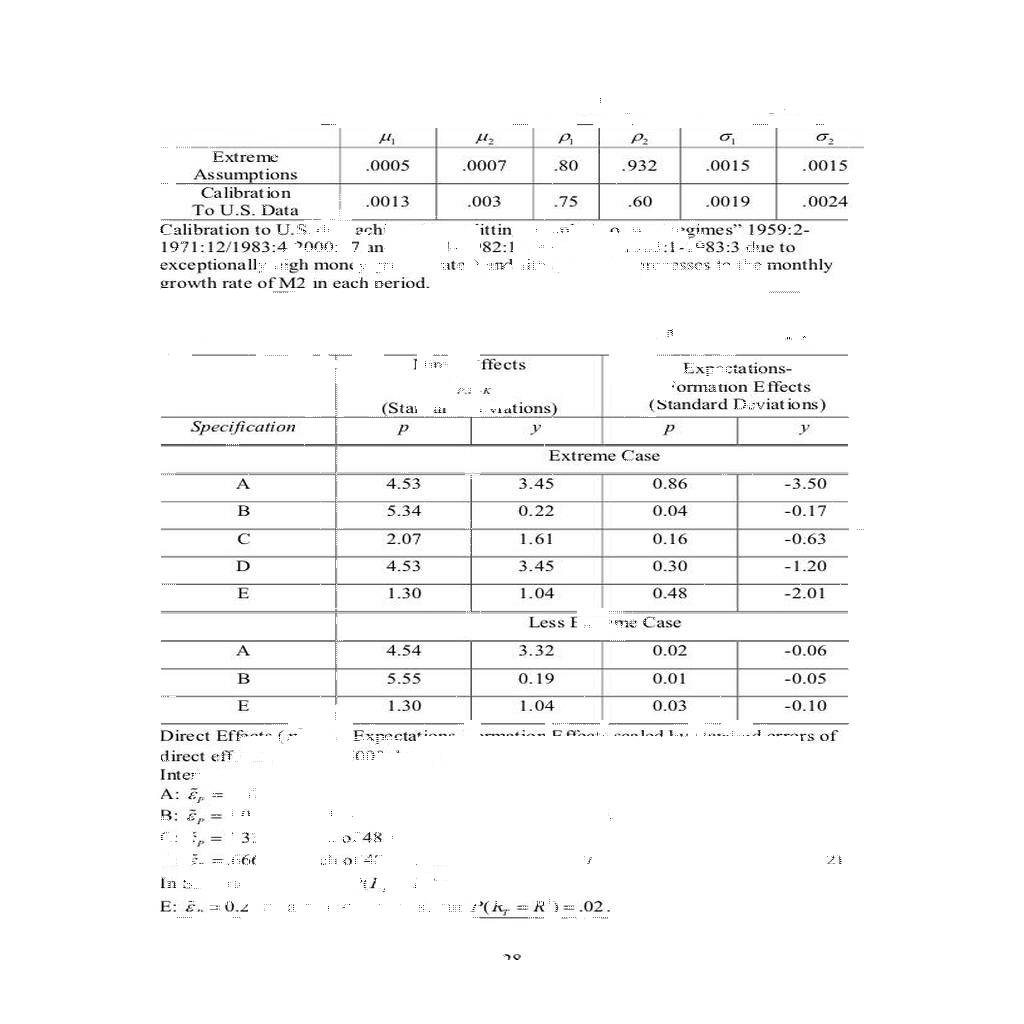